In [1]:
import os
os.chdir('../')
from helpers import *

mousenums:  ['230', '355', '358', '362', '673', '674', '816', '825']


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn

In [5]:
mousenums = ['230', '355', '362', '673', '674', '816', '825']

In [249]:
XsTr = np.empty((7, 2), dtype=list)
YsTr = np.empty((7, 2), dtype=list)
XsTe = np.empty((7, 2), dtype=list)
YsTe = np.empty((7, 2), dtype=list)
Xs = np.empty((7, 2), dtype=list)
Ys = np.empty((7, 2), dtype=list)
MposTe = np.empty((7, 2), dtype=list)

threatsTe = np.empty((7, 1), dtype=list)

for i, mouse in enumerate(mousenums):
    track1, neur1, behav1 = getdicts(foldnames, mouse, 'epm')
    track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
    
    calc1, calc2 = getcalcs(foldnames, mouse, 'epm', 'rat1')
    calc1 = zscore(calc1)
    calc2 = zscore(calc2)
    
    indsTr1, indsTe1 = getinterleavedinds(450, 75, calc1.shape[0])
    indsTr2, indsTe2 = getinterleavedinds(450, 75, calc2.shape[0])
    
    XsTr[i, 0] = calc1[indsTr1]
    XsTr[i, 1] = calc2[indsTr2]
    XsTe[i, 0] = calc1[indsTe1]
    XsTe[i, 1] = calc2[indsTe2]
    Xs[i, 0] = calc1
    Xs[i, 1] = calc2
    
    hdframe = sio.loadmat('headdip_epm/headDip_' + mouse + '.mat')['headDipFrameMS'] - 4
    mpos1 = rescale_epm_mpos(track1['mouse_positionMS'], behav1)
    data1 = np.zeros((calc1.shape[0], 4))
    for frame in hdframe:
        data1[frame[0]:frame[1]+1, 0] = 1
    data1[:, 1] = track1['mouseVelMS'].flatten()
    data1[:, 2:4] = np.abs(mpos1)
    
    for d in range(4):
        if np.var(data1[:, d]) > 0:
            data1[:, d] = zscore(data1[:, d])
    
    
    data2 = np.zeros((calc2.shape[0], 7))
    for j, b_frame in enumerate([behav2['approachFrameMS'], behav2['escapeFrameMS'], behav2['freezeFrameMS']]):
        for frame in b_frame:
            data2[frame[0]:frame[1]+1, j] = 1
    data2[:, 3] = track2['mouseVelMS'].flatten()
    data2[:, 4] = track2['ratVelMS'].flatten()
    data2[:, 5:7] = track2['mouse_positionMS']
    for d in range(7):
        if np.var(data2[:, d]) > 0:
            data2[:, d] = zscore(data2[:, d])
    
    
    mpos2 = track2['mouse_positionMS']
    rpos = track2['rat_positionMS']
    mpos2[:, 0] = minmaxscale(mpos2[:, 0], vmin=0, vmax=70, refmax = np.max(rpos[:, 0]))
    mpos2[:, 1] = minmaxscale(mpos2[:, 1], vmin=0, vmax=28.5)
    
    MposTe[i, 0] = mpos1[indsTe1]
    MposTe[i, 1] = mpos2[indsTe2]
    
    threatsTe[i, 0] = epmthreat(track1['mouse_positionMS'], behav1)[indsTe1]
    
    YsTr[i, 0] = data1[indsTr1]
    YsTr[i, 1] = data2[indsTr2]
    YsTe[i, 0] = data1[indsTe1]
    YsTe[i, 1] = data2[indsTe2]
    Ys[i, 0] = data1
    Ys[i, 1] = data2

In [17]:
import CoCA

In [18]:
from sklearn.cross_decomposition import CCA
import time

In [19]:
assays = ['epm', 'rat1']

In [262]:
coca = CoCA.CoCA(n_components=1, metric='sum', weight_decay=0.0)

In [264]:
t0 = time.time()
coca.fit(XsTr, YsTr)
print(time.time() - t0)

7.1305296421051025


In [265]:
coca.final_loss_

-10.013964653015137

In [266]:
#############################

In [267]:
Zxs, Zys = coca.transform(XsTe, YsTe)

In [268]:
rs = np.zeros((7, 2))
for i in range(7):
    for j in range(2):
        rs[i, j] = pearsonr(Zxs[i, j][:, 0], Zys[i, j][:, 0])[0]

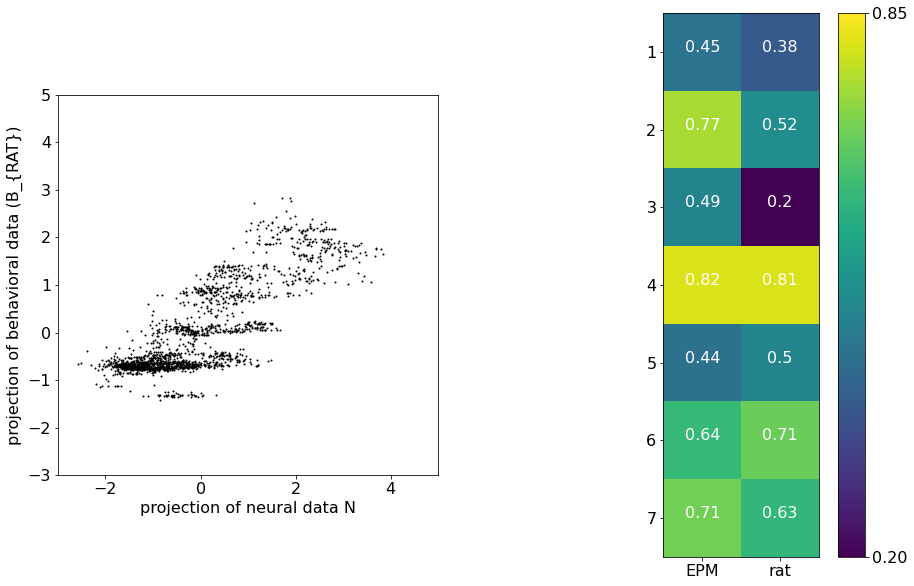

In [269]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(Zxs[3, 1].flatten(), Zys[3, 1].flatten(), s=1, c='k', alpha=1)
plt.xlim(-3, 5)
plt.ylim(-3, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('projection of neural data N')
plt.ylabel('projection of behavioral data (B_{RAT})')

plt.subplot(1, 2, 2)
plt.imshow(rs, vmin=0.2, vmax=0.85)
for i in range(7):
    for j in range(2):
        plt.text(j, i, np.round(rs[i, j], 2), c='w', ha='center')
plt.xticks([0, 1], ['EPM', 'rat'])
plt.yticks(range(7), range(1, 8))
cbar = plt.colorbar()
cbar.set_ticks([0.2, 0.85])
plt.savefig('./elife_figs/3s5D')

In [270]:
coca.y_weights_

array([array([[-0.00397122],
       [ 0.05822773],
       [ 0.59563058],
       [-0.80113543]]),
       array([[-0.07927547],
       [ 0.0603572 ],
       [ 0.0053443 ],
       [ 0.14488842],
       [-0.01865164],
       [ 0.95254329],
       [-0.24771877]])], dtype=object)

In [271]:
varNames1 = ['head dip', 'mouse velocity', '|x pos|', '|y pos|']
varNames2 = ['approach', 'escape', 'freeze', 'mouse velocity', 'rat velocity', 'x pos', 'y pos']

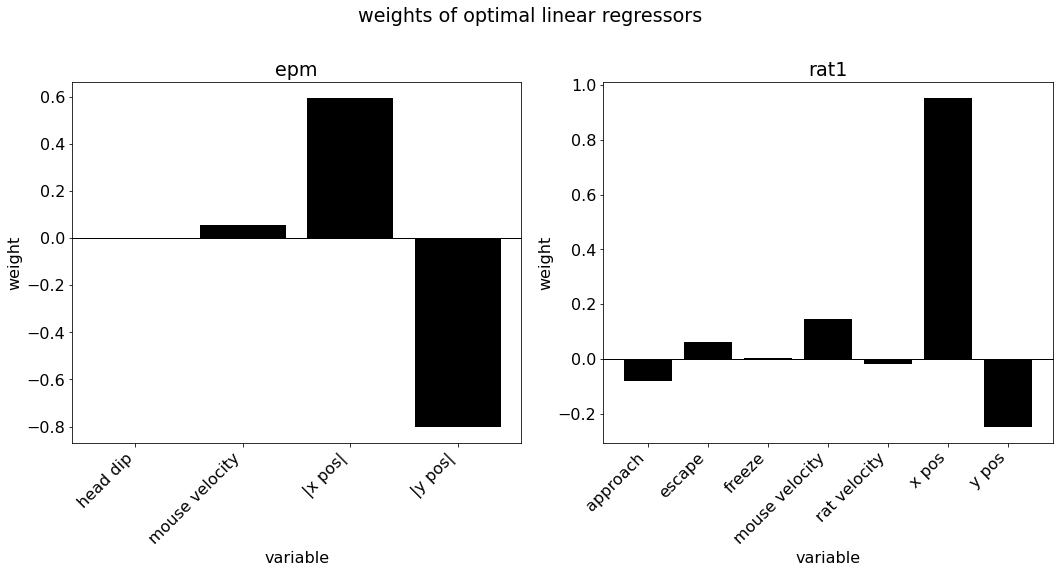

In [272]:
dmod = {}
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
w = coca.y_weights_[0].flatten()
w /= np.linalg.norm(w)
dmod['Wepm'] = w
dmod['epmlabels'] = varNames1
plt.bar(np.arange(w.size), w, color='k')
plt.xticks(np.arange(len(varNames1)), varNames1, rotation=45, ha = 'right')
#plt.grid()
plt.plot(0, 0, 'k_', ms=2000)
plt.xlabel('variable')
plt.ylabel('weight')
plt.title('epm')

plt.subplot(1, 2, 2)
w = coca.y_weights_[1].flatten()
w /= np.linalg.norm(w)
dmod['Wrat'] = w
dmod['rat1labels'] = varNames2
plt.bar(np.arange(w.size), w, color='k')
plt.xticks(np.arange(len(varNames2)), varNames2, rotation=45, ha = 'right')
#plt.grid()
plt.plot(0, 0, 'k_', ms=2000)
plt.xlabel('variable')
plt.ylabel('weight')
plt.title('rat1')

plt.suptitle('weights of optimal linear regressors', y=1)

plt.tight_layout()

plt.savefig('./elife_figs/3s5B')

In [273]:
cta = [[] for i in range(len(mousenums))]
for i, mouse in enumerate(mousenums):
    track1, neur1, behav1 = getdicts(foldnames, mouse, 'epm')
    track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
    
    calc1, calc2 = getcalcs(foldnames, mouse, 'epm', 'rat1')
    calc1 = zscore(calc1)
    calc2 = zscore(calc2)
    
    for cell in range(calc1.shape[1]):
        ctype = celltypebehav(calc1[:, cell], behav1)
        cta[i].append(ctype)
for i in range(len(mousenums)):
    cta[i] = np.array(cta[i])
ctall = np.concatenate(cta)

In [274]:
mus = [np.mean(ws[ctall == typ]) for typ in ['o', 'n', 'c']]
sems = [sem(ws[ctall == typ]) for typ in ['o', 'n', 'c']]

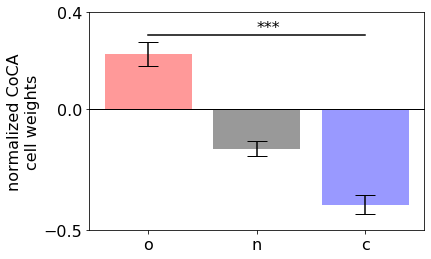

In [275]:
colors = ['r', 'k', 'b']
for i in range(3):
    plt.bar(i, mus[i], color=colors[i], alpha=0.4)
for i in range(3):
    plt.errorbar(i, mus[i], sems[i], fmt='k_', ms=0, capsize=10)
plt.plot([0, 2], [0.305, 0.305], 'k')
plt.text(1, 0.32, '***')
plt.ylim(-0.5, 0.4)
plt.yticks([-0.5, 0, 0.4])
plt.xticks([0, 1, 2], ['o', 'n', 'c'])
plt.ylabel('normalized CoCA\ncell weights')
plt.plot(0, 0, 'k_', ms=2000)

plt.savefig('./elife_figs/3s5C')

In [276]:
ranksums(ws[ctall == 'o'], ws[ctall == 'c'])

RanksumsResult(statistic=7.899956494401101, pvalue=2.7900079380977966e-15)

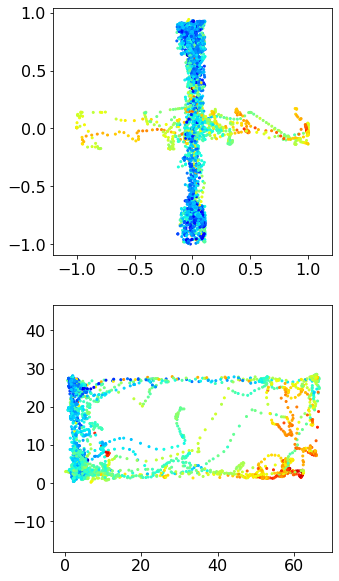

In [277]:
plt.figure(figsize=(5, 10))
plt.subplot(2, 1, 1)
plt.scatter(MposTe[5, 0][:, 0], MposTe[5, 0][:, 1], s=4, cmap='jet', c=Zxs[5, 0].flatten())
plt.axis('equal')
plt.subplot(2, 1, 2)
plt.scatter(MposTe[5, 1][:, 0], MposTe[5, 1][:, 1], s=4, cmap='jet', c=Zxs[5, 1].flatten())
plt.axis('equal')

plt.savefig('./elife_figs/3s5E')

In [278]:
Mpos_EPM = np.concatenate(MposTe[:, 0])
Mpos_Rat = np.concatenate(MposTe[:, 1])

Zx_EPM = np.concatenate(Zxs[:, 0].flatten())
Zx_Rat = np.concatenate(Zxs[:, 1].flatten())

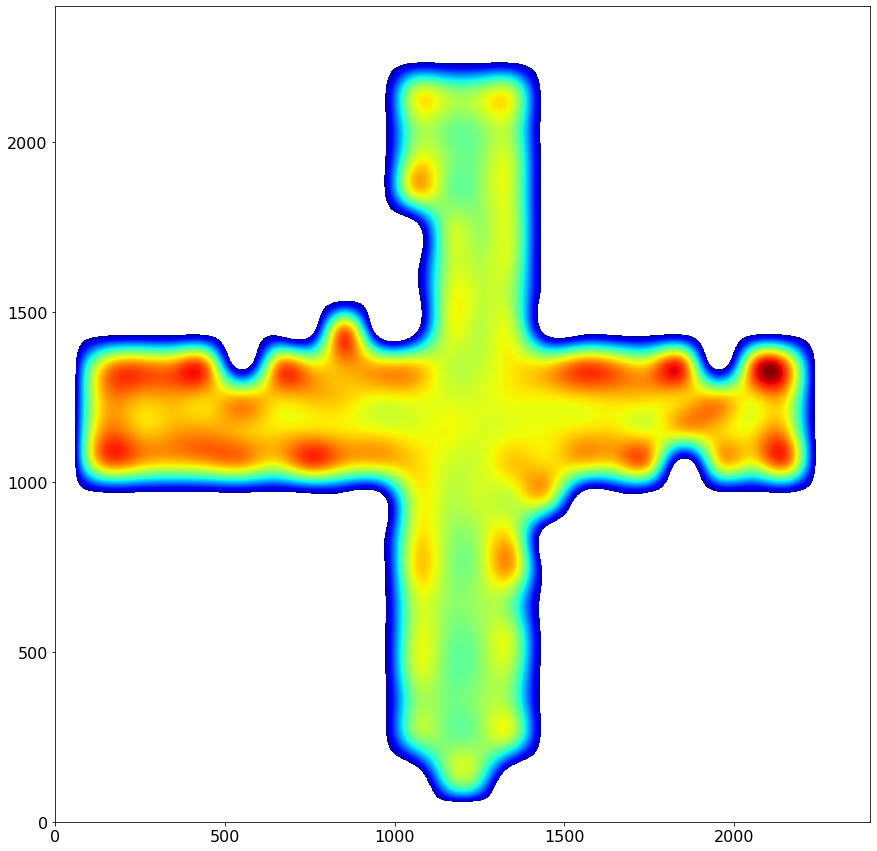

In [279]:
plotheatmap(Mpos_EPM, Zx_EPM, step=0.1, interpstep=0.001)
plt.savefig('./elife_figs/3s5Ft')

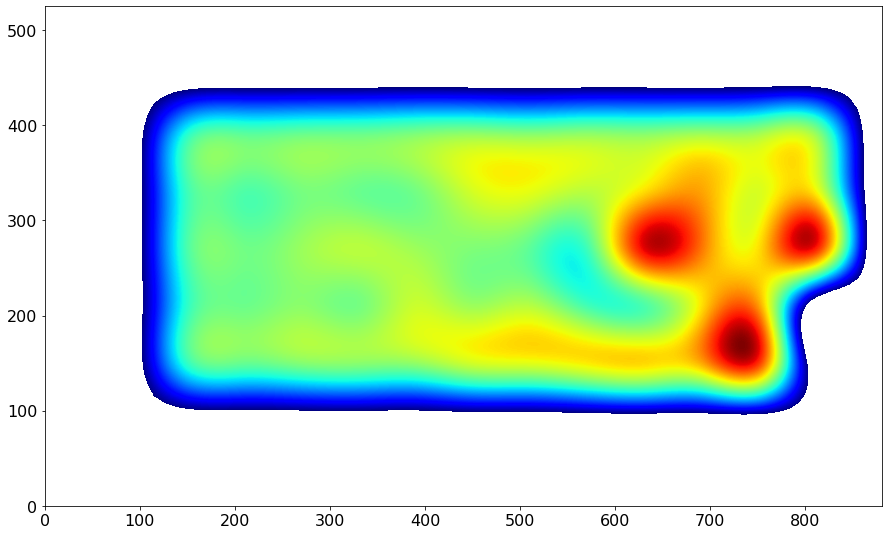

In [280]:
plotheatmap(Mpos_Rat, Zx_Rat, step=6, interpstep=0.1)
plt.xlim(0, 880)
plt.savefig('./elife_figs/3s5Fb')

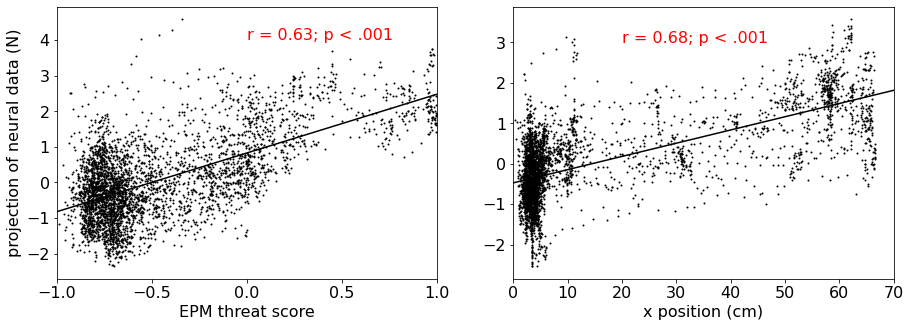

In [281]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(threatsTe[5, 0].flatten(), Zxs[5, 0].flatten(), s=1, c='k')
lr = LR()
lr.fit(threatsTe[5, 0][:, None], Zxs[5, 0].flatten())
plt.plot([-1, 1], lr.predict(np.array([-1, 1])[:, None]), 'k')
plt.xlim([-1, 1])
plt.text(0, 4, 'r = ' + str(np.round(pearsonr(threatsTe[5, 0].flatten(), Zxs[5, 0].flatten())[0], 2)) + '; p < .001', color='r')
plt.xlabel('EPM threat score')
plt.ylabel('projection of neural data (N)')

plt.subplot(1, 2, 2)
plt.scatter(MposTe[5, 1][:, 0].flatten(), Zxs[5, 1].flatten(), s=1, c='k')
lr = LR()
lr.fit(MposTe[5, 1][:, 0][:, None], Zxs[5, 1].flatten())
plt.plot([0, 70], lr.predict(np.array([0, 70])[:, None]), 'k')
plt.xlim([0, 70])
plt.text(20, 3, 'r = ' + str(np.round(pearsonr(MposTe[5, 1][:, 0].flatten(), Zxs[5, 1].flatten())[0], 2)) + '; p < .001', color='r')
plt.xlabel('x position (cm)')

plt.savefig('./elife_figs/3s5G')

In [283]:
rs_m = [[pearsonr(threatsTe[i, 0].flatten(), Zxs[i, 0].flatten())[0] for i in range(7)],
     [pearsonr(MposTe[i, 1][:, 0].flatten(), Zxs[i, 1].flatten())[0] for i in range(7)]]

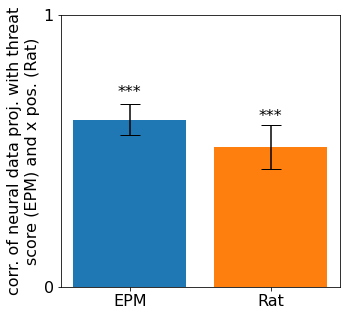

In [284]:
plt.figure(figsize=(5, 5))
plt.bar(0, np.mean(rs_m[0]))
plt.errorbar(0, np.mean(rs_m[0]), sem(rs_m[0]), fmt='k_', ms=0, capsize=10)

plt.bar(1, np.mean(rs_m[1]))
plt.errorbar(1, np.mean(rs_m[1]), sem(rs_m[1]), fmt='k_', ms=0, capsize=10)

plt.ylim(0, 1)
plt.yticks([0, 1])
plt.xticks([0, 1], ['EPM', 'Rat'])

plt.text(0, 0.7, '***', ha='center')
plt.text(1, 0.61, '***', ha='center')

plt.ylabel('corr. of neural data proj. with threat\nscore (EPM) and x pos. (Rat)')
plt.savefig('./elife_figs/3s5H')